In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy
import cupy as cp
import matplotlib.patches as patches


import sscCdi
from sscCdi import *
sscCdi.__version__

'0.10.0'

### Nearfield Ptychography  

In [16]:
def projection_Rspace_multiprobe_RAAR_cupy(wavefronts,obj,probes,positions,epsilon):
    probes_numerator, probes_denominator = RAAR_multiprobe_update_probe_cupy(wavefronts, obj, probes.shape,positions, epsilon=epsilon) 
    obj_numerator, obj_denominator   = RAAR_multiprobe_update_object_cupy(wavefronts, probes, obj.shape, positions,epsilon=epsilon)
    return probes_numerator, probes_denominator, obj_numerator, obj_denominator

def RAAR_multiprobe_update_object_cupy(wavefronts, probe, object_shape, positions,epsilon):

    modes,m,n = probe.shape
    k,l = object_shape

    probe_sum  = cp.zeros((k,l),dtype=complex)
    wave_sum   = cp.zeros((k,l),dtype=complex)
    probe_intensity  = cp.abs(probe)**2
    probe_conj = cp.conj(probe)

    for mode in range(modes):
        for index, (posx, posy) in enumerate((positions)):
            probe_sum[posy:posy + m , posx:posx+n] += probe_intensity[mode]
            wave_sum[posy:posy + m , posx:posx+n]  += probe_conj[mode]*wavefronts[index,mode] 

    return wave_sum,(probe_sum + epsilon)

def RAAR_multiprobe_update_probe_cupy(wavefronts, obj, probe_shape,positions, epsilon=0.01):
    
    l,m,n = probe_shape

    object_sum = cp.zeros((m,n),dtype=complex)
    wave_sum = cp.zeros((l,m,n),dtype=complex)
    
    obj_intensity = cp.abs(obj)**2
    obj_conj = cp.conj(obj)
    
    for index, (posx, posy) in enumerate(positions):
        object_sum += obj_intensity[posy:posy + m , posx:posx+n] 
        for mode in range(l):
            wave_sum[mode] += obj_conj[posy:posy + m , posx:posx+n]*wavefronts[index,mode]

    return wave_sum,(object_sum + epsilon)

def RAAR_multiplane(diffraction_patterns,positions,obj,probe,inputs,delta_z_threshold=0):
    
    iterations = inputs['iterations']
    beta       = inputs['beta']
    epsilon    = inputs['epsilon']
    dx         = inputs['object_pixel']
    wavelength = inputs['wavelength']
    distance   = inputs['detector_distance']
    n_of_modes = inputs["incoherent_modes"]
    fresnel_regime = inputs["fresnel_regime"]
    probe_support  = inputs["probe_support"] 

    if fresnel_regime == True:
        pass
    else:
        inputs['source_distance'] = None

    diffraction_patterns = cp.array(diffraction_patterns) 
    positions = cp.array(positions)
    obj = cp.array(obj)
    probe = cp.array(probe)

    if probe_support is None:
        probe_support = cp.ones_like(probe) + 1j
    else:
        probe_support = cp.array(probe_support) + 1j

    obj_matrix = cp.ones((n_of_modes,obj.shape[-2],obj.shape[-1]),dtype=complex) 
    obj_matrix[:] = obj # create matrix of repeated object to facilitate slice-wise product with probe modes
    
    shapey,shapex = probe.shape
    
    probe_modes = cp.empty((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
    for i in range(0,probe_modes.shape[0]):
        if i == 0:
            probe_modes[i] = probe
        else:
            probe_modes[:] = cp.random.rand(*probe.shape)
    
    # inputs["detector_position"] = np.max(positions[:,2] )    
        
    mean_z_values = get_mean_z_values(positions) # get a mean value for the z_position at each plane. this is used to propagate object between planes
    print(mean_z_values)
    error = cp.zeros((iterations,1))
    detector_distance_array = inputs["detector_position"] - positions[:,2]
    print(detector_distance_array)
    posx,posy,posz = positions[:,0], positions[:,1], positions[:,2]

    print(f'Performing ptychography over {int(positions[:,3].max())} planes')
    
    for iteration in range(0,iterations):
        """
        RAAR update function:
        psi' = [ beta*(Pf*Rr + I) + (1-2*beta)*Pr ]*psi
        psi' = beta*(Pf*Rr + I)*psi + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*Rr*psi + psi) + (1-2*beta)*Pr*psi (eq 1)
        """

        probes_numerator = np.zeros_like(probe_modes)
        probes_denominator = np.zeros_like(probe_modes)
        obj_numerator = np.zeros_like(obj_matrix)
        obj_denominator = np.zeros_like(obj_matrix)

        for plane_number in range(0,1+int(positions[:,3].max())): # ptycho at plane z
            
            print(f"\tPtycho @ plane #{plane_number}")
            
            inputs["detector_distance"] = inputs["detector_position"] - positions[0,2] # new distance between sample and detector   
            wavefronts = cp.ones((positions.shape[0],n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex) # wavefronts contain the wavefront for each probe mode, and for all probe positions
            
            for index, (pos_x, pos_y, pos_z,_) in enumerate(positions): # get wavefronts at new z-position
                wavefronts[index] = probe_modes*obj_matrix[:,pos_y:pos_y + shapey , pos_x:pos_x+ shapex] # get wavefront for a specific probe position (extract part of the obj matrix)

            for index in range(positions.shape[0]):

                inputs["detector_distance"]  = detector_distance_array[index]

                obj_box = obj_matrix[:,posy[index]:posy[index] + shapey , posx[index]:posx[index]+ shapex]

                psi_after_Pr = probe_modes*obj_box

                psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
                psi_after_projection_Fspace, _ = update_exit_wave_multiprobe_cupy(psi_after_reflection_Rspace,diffraction_patterns[index],inputs) # Projection in Fourier space
                wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

            probes_n, probes_d, obj_n, obj_d = projection_Rspace_multiprobe_RAAR_cupy(wavefronts,obj_matrix[0],probe_modes,positions[:,0:2],epsilon) # Update Object and Probe! Projection in Real space (consistency condition)

            probes_numerator += probes_n
            probes_denominator += probes_d
            obj_numerator += obj_n
            obj_denominator += obj_d    

        # Update Object and Probe for all 3 planes together! Projection in Real space (consistency condition)
        probe_modes = probes_numerator/probes_denominator
        single_obj_box = obj_numerator/obj_denominator
        obj_matrix[:] = single_obj_box # update all obj slices to be the same;

        propagated_probe = sscCdi.fresnel_propagator_cone_beam(probe_modes[0].get(),inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"].get())
        mean = np.mean(np.angle(propagated_probe))
        std=np.std(np.angle(propagated_probe))
        fig, ax = plt.subplots(1,6,figsize=(20,10))
        a = obj_matrix[0].get()
        b = probe_modes[0].get()
        c = propagated_probe
        ax[0].imshow(np.abs(a))
        ax[1].imshow(np.angle(a))
        ax[2].imshow(np.abs(b))
        ax[3].imshow(np.angle(b))            
        ax[4].imshow(np.abs(c))            
        ax[5].imshow(np.angle(c),vmin=mean-4*std,vmax=mean+4*std)            
        plt.show()

            # probe_modes = probe_modes[:]*probe_support
            
#             if plane_number != int(positions[:,3].max()): # if not last plane
#                 distance_to_next_plane = -(mean_z_values[plane_number+1] - mean_z_values[plane_number])
#                 print(mean_z_values)
#                 print('\tPropagating to next plane', distance_to_next_plane) # Propagate object to next plane
#                 obj_matrix[:] = fresnel_propagator_cone_beam(obj_matrix[0],inputs["wavelength"],inputs["detector_pixel_size"],distance_to_next_plane) # propagate obj_matrix to new plane in parallel geometry

#                 fig, ax = plt.subplots(1,4,dpi=150)
#                 a = obj_matrix[0].get()
#                 b = probe_modes[0].get()
#                 ax[0].imshow(np.abs(a))
#                 ax[1].imshow(np.angle(a))
#                 ax[2].imshow(np.abs(b))
#                 ax[3].imshow(np.angle(b))            
#                 plt.show()

                
        iteration_error = get_magnitude_error(diffraction_patterns,wavefronts[:,0,:,:],inputs) # should we insert more modes to calculate error?

        # print('\r', end='')
        print(f'Iteration {iteration+1}/{iterations} \tError: {iteration_error:.2e}')

        error[iteration] = iteration_error

    return obj_matrix[0].get(), probe_modes.get(), error.get()



def get_equivalent_geometry(positions,z1z2,delta_z_threshold = 0.0005):
    """
    Equivalent geometry according to: Near-field multi-slice ptychography: quantitative phase imaging of optically thick samples with visible light and X-rays
    """
    
    z1 = positions[:,2].max()
    z2 = z1z2 - z1
    T = z1 - positions[:,2].min() # sample thickness
    dz = z1 - positions[:,2]
    Mdz = (z1+z2)/(z1-dz)
    positions = np.hstack((positions,dz.reshape(-1, 1),Mdz.reshape(-1, 1),np.zeros_like(dz).reshape(-1, 1)))
    print(dz)
    print(Mdz)
    plane_number = 0
    positions[0,5] = 0
    for i in range(0,positions.shape[0]-1):
        diff = positions[i,2] - positions[i+1,2]
        if diff  > delta_z_threshold:
            plane_number +=1
        positions[i+1,5] = plane_number

    positions[:,2] -= z1z2 # change origin to the detector plane
    # positions[:,2] *= -1
    positions[:,2] = positions[:,2]*positions[:,4] # change z values to equivalent geometry
    # print(positions[:,0])
    positions[:,0] = positions[:,0]*positions[:,4] # change x values to equivalent geometry
    # print(positions[:,0])
    # print(positions[:,1])
    positions[:,1] = positions[:,1]*positions[:,4] # change y values to equivalent geometry
    # print(positions[:,1])
    # positions[:,2] *= -1 # change origin back to focus
    # positions[:,2] += z1z2
    positions[:,2] -= positions[:,2].min()
    new_detector_position = -positions[:,2].min()

    return positions[:,[0,1,2,5]], new_detector_position


def get_mean_z_values(positions_selected):
    mean_z_values = []
    for i in range(0,int(positions_selected[:,3].max()+1)):
        mean_z_position = positions_selected[positions_selected[:, 3] == i][:,2].mean()
        mean_z_values.append(mean_z_position)
    return mean_z_values

### Load positions

[[-0.00200836 -0.00427054 -0.00018443]
 [-0.00200825 -0.00427054  0.00052781]
 [-0.00200815 -0.00427055  0.00129023]
 ...
 [-0.00189938 -0.00428152 -0.00672195]
 [-0.00189928 -0.00428152 -0.00672195]
 [-0.00189918 -0.00428152 -0.00672195]]


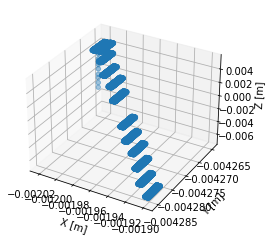

In [14]:
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')
positions0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/positions.npy')*1e-3
print(positions0)

folder_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/'
data_shape = (2048,2048)
n_points_per_z = 41*40
n_of_z = 12

# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(positions0[:,0],positions0[:,1],positions0[:,2],'o')
ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')
# plt.plot(positions0[:,0],positions0[:,1],'o')

z1z2 = 1

### Load data

Data #0 shape = (41, 40, 2048, 2048). 1640
Positions #0 shape = (1640, 3)
Data #1 shape = (41, 40, 2048, 2048). 1640
Positions #1 shape = (1640, 3)
Data #2 shape = (41, 40, 2048, 2048). 1640
Positions #2 shape = (1640, 3)


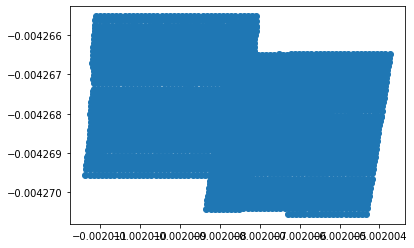

In [4]:
%matplotlib inline

A = 3 # wanted number of z positions

DPs_selected = np.empty((A*n_points_per_z,2048,2048),dtype=np.uint16)
positions_selected = np.empty((A*n_points_per_z,3))

for i in range(0,A):
    data = np.load(folder_path+f"z_{i}.npy")
    print(f"Data #{i} shape = {data.shape}. {data.shape[0]*data.shape[1]}")
    DP = data.reshape(n_points_per_z,data_shape[0],data_shape[1])
    positions1 = positions0[i*n_points_per_z:(i+1)*n_points_per_z]
    print(f"Positions #{i} shape = {positions1.shape}")    
   
    DPs_selected[i*n_points_per_z:(i+1)*n_points_per_z] = DP  
    positions_selected[i*n_points_per_z:(i+1)*n_points_per_z] = positions1
    
DPs_selected = np.delete(DPs_selected,range(1640,1640*2),axis=0)
positions_selected = np.delete(positions_selected,range(1640,1640*2),axis=0) 

DPs_selected = DPs_selected[20:] # remove first bad 
positions_selected = positions_selected[20:]

fig, ax = plt.subplots()
ax.plot(positions_selected[:,0],positions_selected[:,1],'o')

# for py,px in zip(positions_selected[:,0],positions_selected[:,1]):
#     point=(py,px)
#     rect = patches.Rectangle(point, 2048*1.44e-6, 2048*1.44e-6, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

In [5]:
# DPs_selected = DPs_selected[:,500:-500,500:-500]

In [6]:
# np.save('positions.npy',positions_selected)
# np.save('DPs_selected.npy',DPs_selected)
# DPs_selected = np.load('DPs_selected.npy')
# positions_selected = np.load('positions.npy')

DPs_selected.shape, positions_selected.shape,positions_selected    

((3260, 2048, 2048),
 (3260, 3),
 array([[-0.00200629, -0.00427055,  0.00527011],
        [-0.00200619, -0.00427055,  0.00527011],
        [-0.00200609, -0.00427055,  0.00527011],
        ...,
        [-0.0020073 , -0.00426552,  0.00327806],
        [-0.0020072 , -0.00426553,  0.00327806],
        [-0.00200709, -0.00426553,  0.00327806]]))

In [7]:
# fig, ax = plt.subplots(dpi=150)
# ax.imshow(DPs_selected[0])

In [8]:
# positions_selected = positions_selected[0:1620]
# DPs_selected = DPs_selected[0:1620]

### Call Ptychography

z1=0.005270114, z2=0.994729886, M=189.74921605111388
[[-0.00200709 -0.00426553  0.00327806]
 [-0.0020072  -0.00426553  0.00327806]
 [-0.0020073  -0.00426552  0.00327806]
 ...
 [-0.00200609 -0.00427055  0.00527011]
 [-0.00200619 -0.00427055  0.00527011]
 [-0.00200629 -0.00427055  0.00527011]]
Minimal required distance from focus = 1.742mm
Object pixel = 1.44e-06 m
Probe shape = (2048, 2048)
[1.992049e-03 1.992049e-03 1.992050e-03 ... 4.000000e-09 6.000000e-09
 8.000000e-09]
[305.05801441 305.05801441 305.05810747 ... 189.74936007 189.74943208
 189.74950409]
All positions:  (3260, 4)
Deleting 3060 slices


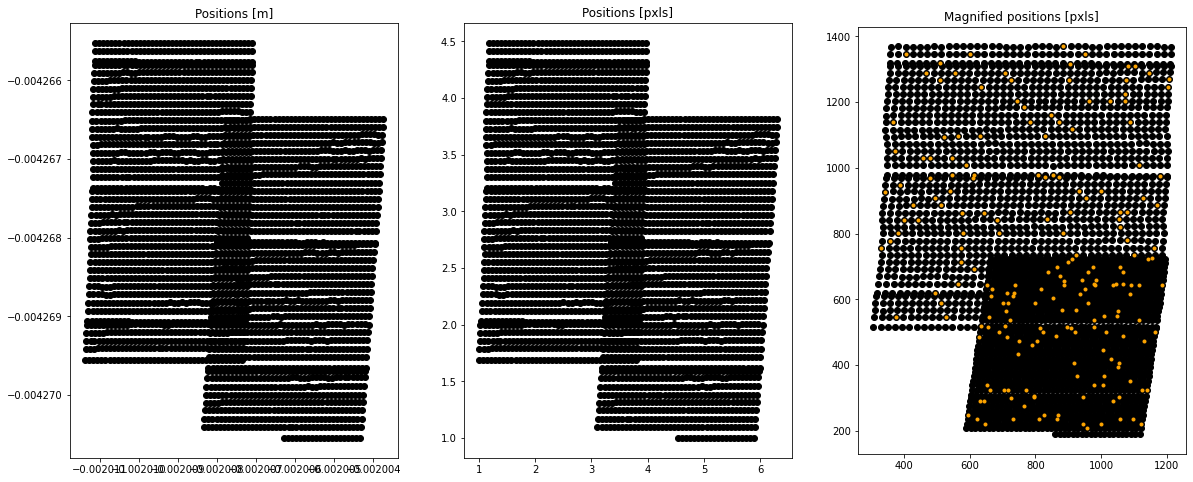

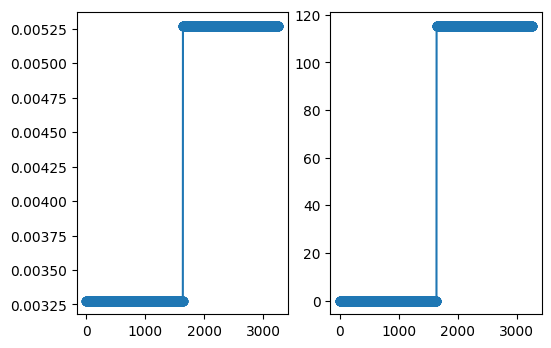

Size of the array: 1.5625 GB
Object shape = (3754, 3917)
FOV = [5405.76 5640.48] um2
Data shape = (200, 2048, 2048)
Positions shape = (200, 4)
(200, 4) (200, 2048, 2048) (2048, 2048) (3754, 3917) {'n_cpus': 32, 'energy': 22, 'detector_position': 188.74921605111388, 'detector_distance': -0.0, 'detector_pixel_size': 1.44e-06, 'source_distance': 0, 'wavelength': 5.6356453357367875e-11, 'object_pixel': 1.44e-06, 'object_padding': 1, 'object_shape': (3754, 3917), 'iterations': 10, 'fresnel_regime': True, 'probe_support': None, 'incoherent_modes': 1, 'beta': 0.9, 'epsilon': 0.001}
[array(56.50161384)]
[188.74875075 188.74893687 188.74893687 188.74884381 188.74884381
 188.74893687 188.74912299 188.74912299 188.74912299 188.74912299
 188.74912299 188.74912299 188.74912299 188.74912299 188.74921605
 188.74921605 188.74921605 188.74912299 188.74912299 188.74893687
 188.74893687 188.74893687 188.74893687 188.74902993 188.74893687
 188.74884381 188.74884381 188.74875075 188.74875075 188.74884381
 

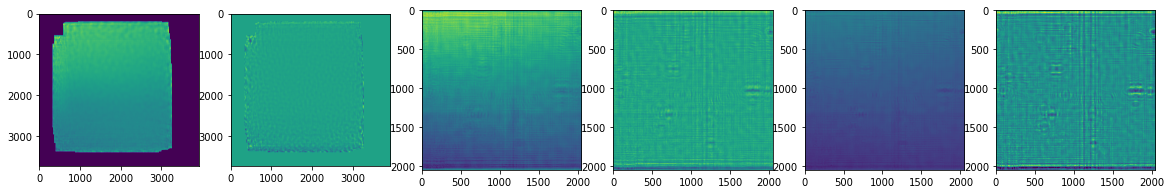

Iteration 1/10 	Error: 1.33e-03
	Ptycho @ plane #0


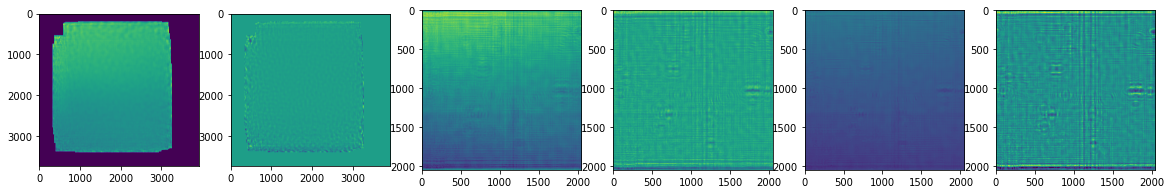

Iteration 2/10 	Error: 1.20e-03
	Ptycho @ plane #0


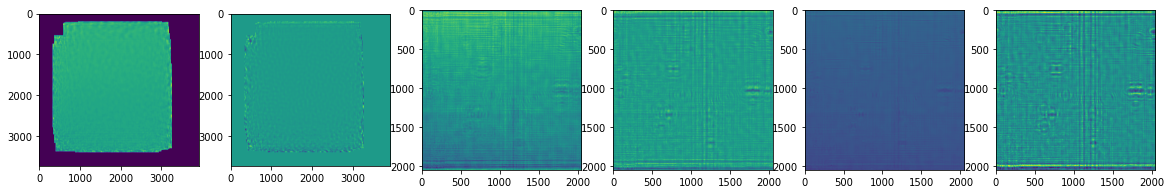

Iteration 3/10 	Error: 1.33e-03
	Ptycho @ plane #0


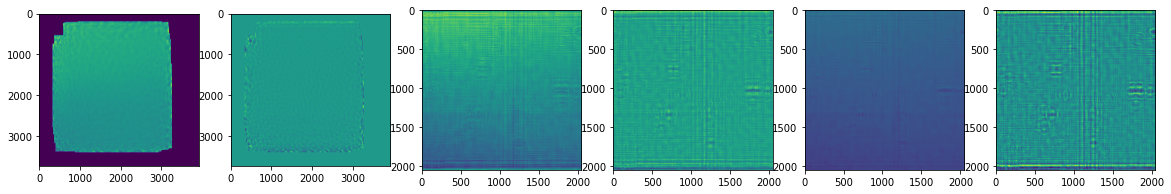

Iteration 4/10 	Error: 1.32e-03
	Ptycho @ plane #0


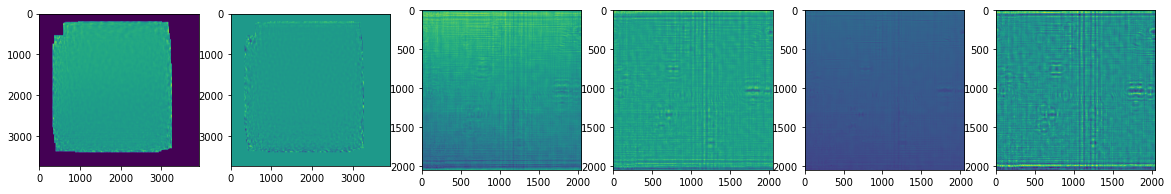

Iteration 5/10 	Error: 1.32e-03
	Ptycho @ plane #0


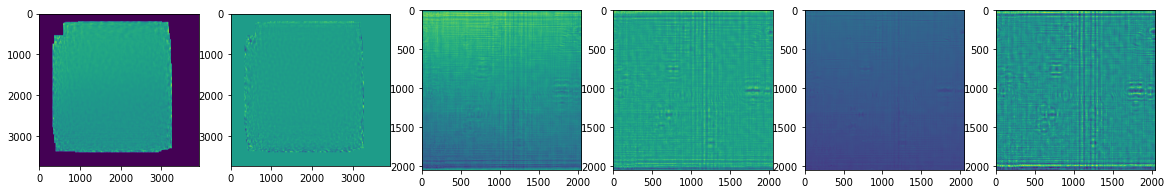

Iteration 6/10 	Error: 1.32e-03
	Ptycho @ plane #0


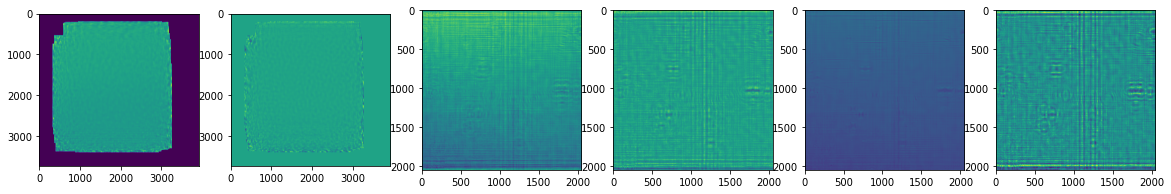

Iteration 7/10 	Error: 1.32e-03
	Ptycho @ plane #0


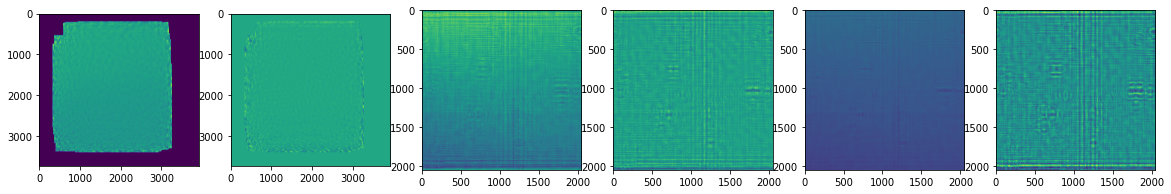

Iteration 8/10 	Error: 1.32e-03
	Ptycho @ plane #0


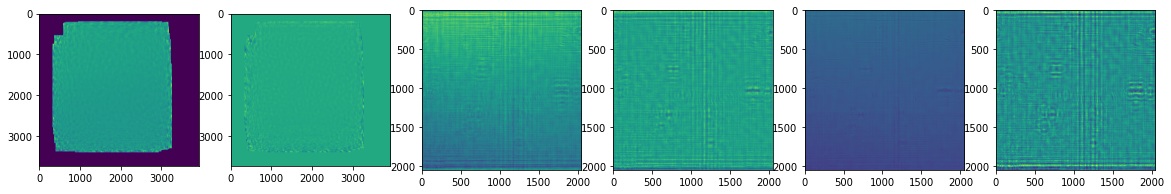

Iteration 9/10 	Error: 1.32e-03
	Ptycho @ plane #0


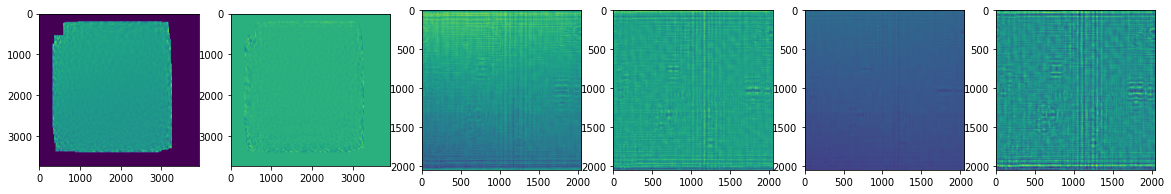

Iteration 10/10 	Error: 1.32e-03


In [18]:
%matplotlib inline

try:
    import cupy as cp
    cp.cuda.memory.MemoryPool().free_all_blocks()
except:
    print('exception')
    
positions = positions_selected.copy()
DPs_selected = DPs_selected[::-1]
positions = positions[::-1]


z1 = np.max(positions0[:,2])
z2 = 1 - z1
M0 = (z2+z1)/z1
print(f'z1={z1}, z2={z2}, M={M0}')

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_position": z2*M0,    
"detector_distance": z2*M0,    
"detector_pixel_size": 1.44e-6, # PCO pixel size with lens 
"source_distance": 0, # should be 0 if parallel beam
}

# positions[:,0:2] *= M0
print(positions)

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

waist = 250e-9/2
zmin = 2*np.pi*waist**2/wavelength
print(f'Minimal required distance from focus = {zmin*1e3:.3f}mm')

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')


probe = np.ones_like(DPs_selected[0])
print(f'Probe shape = {probe.shape}')

fig, ax = plt.subplots(1,3,figsize=(20,8))
ax[0].plot(positions[:,0],positions[:,1],'o',color='black')
ax[0].set_title('Positions [m]')

inputs["object_padding"] = 1
positions[:,0:2] = convert_probe_mogno_positions_meters_to_pixels(positions[:,0:2].copy(),inputs["object_pixel"],inputs["object_padding"])

ax[1].plot(positions[:,0],positions[:,1],'o',color='black')
ax[1].set_title('Positions [pxls]')

fig2, ax2 = plt.subplots(1,2,dpi=100)
ax2[0].plot(positions[:,2],'o-',)
positions, new_detector_position = get_equivalent_geometry(positions,z1z2)
inputs["detector_distance"] = new_detector_position
ax2[1].plot(positions[:,2],'o-')
positions[:,3] = np.round(positions[:,3])
print('All positions: ', positions.shape)
ax[2].plot(positions[:,0],positions[:,1],'o',color='black')

if 1: # remove random points from data
    n_of_points_to_keep = 200
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    positions = np.delete(positions,slices_to_ignore,axis=0)
    DPs = np.delete(DPs_selected,slices_to_ignore,axis=0)

ax[2].plot(positions[:,0],positions[:,1],'.',color='orange')
ax[2].set_title('Magnified positions [pxls]')
ax[2].set_aspect('equal')
# for py,px in zip(positions[:,0],positions[:,1]):
    # point=(py,px)
    # rect = patches.Rectangle(point, 2048, -2048, linewidth=1, edgecolor='r', facecolor='none')
    # ax[2].add_patch(rect)
plt.show()

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

object_padding = 500
inputs["object_shape"] = sscCdi.set_object_shape(object_padding, DPs.shape, positions[:,0:2])
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')
print(f'FOV = {np.asarray(inputs["object_shape"])*inputs["object_pixel"]*1e6} um2')
print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
# probe_guess = DPs.mean(0)
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10   
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.001 # RAAR; small value to add to probe/object update denominator



print(positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape, inputs)
RAAR_obj, RAAR_probes, _ = RAAR_multiplane(DPs,positions,obj_guess,probe_guess,inputs)

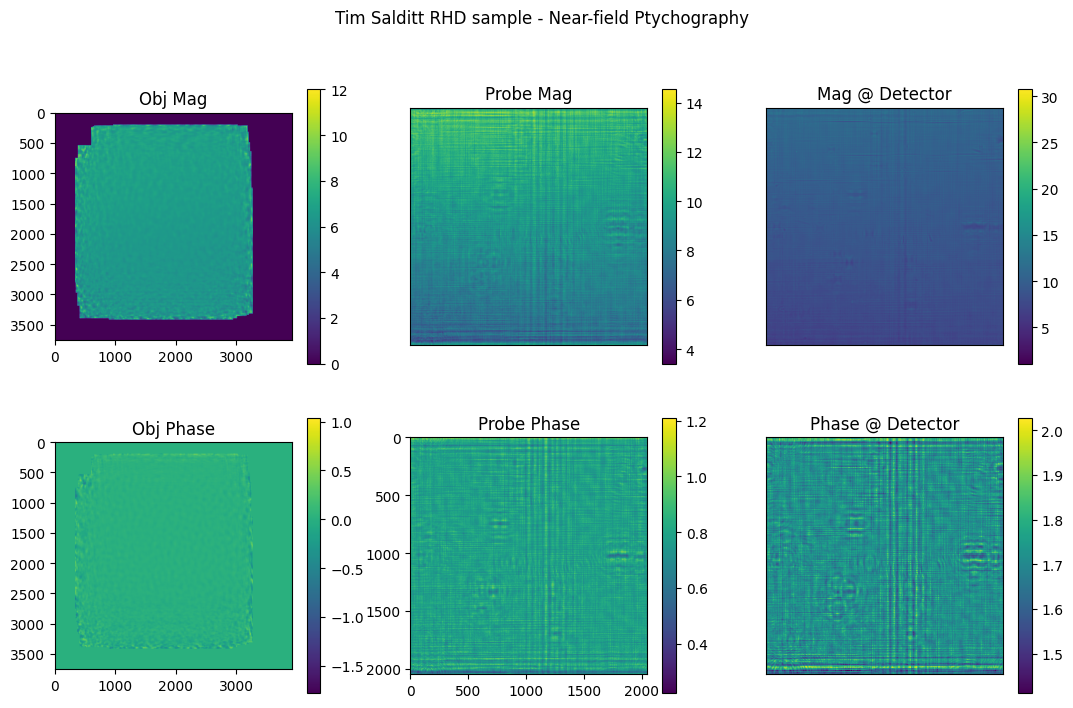

((3754, 3917), (1, 2048, 2048))

In [19]:
# print(inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],float(inputs["source_distance"]))
propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"].get())


if 1: # plot
    fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
    im1=ax[0,0].imshow(np.abs(RAAR_obj))
    ax[0,0].set_title('Obj Mag')
    # ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
    fig.colorbar(im1, ax=ax[0, 0])

    im2 = ax[1,0].imshow(np.angle(RAAR_obj))
    ax[1,0].set_title('Obj Phase')
    fig.colorbar(im2, ax=ax[1, 0])

    im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
    ax[0,1].set_title('Probe Mag')
    fig.colorbar(im3, ax=ax[0, 1])

    im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
    ax[1,1].set_title('Probe Phase')
    fig.colorbar(im4, ax=ax[1, 1])

    im5=ax[0,2].imshow(np.abs(propagated_probe))
    ax[0,2].set_title('Mag @ Detector')
    fig.colorbar(im5, ax=ax[0, 2])

    mean = np.mean(np.angle(propagated_probe))
    std=np.std(np.angle(propagated_probe))
    im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
    ax[1,2].set_title('Phase @ Detector')
    fig.colorbar(im6, ax=ax[1,2])

    fig.suptitle('Tim Salditt RHD sample - Near-field Ptychography')

    for i, ax in enumerate(ax.ravel()):
        if i==3 or i==0 or i ==4: continue
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

RAAR_obj.shape, RAAR_probes.shape

In [21]:
def save_RAAR_to_hdf5_with_propagated_probe(RAAR_obj, RAAR_probes, propagated_probe, output_path):
    """
    Saves RAAR_obj, RAAR_probes, and propagated_probe to a HDF5 file.

    Parameters:
    - RAAR_obj: The RAAR object to be saved.
    - RAAR_probes: The RAAR probes to be saved.
    - propagated_probe: The propagated probe to be saved.
    - output_path: The path to the output HDF5 file.
    """
    with h5py.File(output_path, 'w') as hdf_file:
        hdf_file.create_dataset('RAAR_obj', data=RAAR_obj)
        hdf_file.create_dataset('RAAR_probes', data=RAAR_probes)
        hdf_file.create_dataset('propagated_probe', data=propagated_probe)

output_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/RAAR.h5'
save_RAAR_to_hdf5_with_propagated_probe(RAAR_obj, RAAR_probes, propagated_probe, output_path)